In [ ]:
import zipfile
with zipfile.ZipFile('/content/archive (1) (1).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [ ]:
!pip install deepface


100%|██████████| 7178/7178 [02:13<00:00, 53.60it/s]


Accuracy: 55.24%

Confusion Matrix:
 [[ 406    7  125   61  156  171   32]
 [  34   32   15    4   14   12    0]
 [ 111    4  383   64  172  213   77]
 [  56    1   91 1371  144   81   30]
 [  92    4  114  106  694  205   18]
 [ 134    6  183   98  290  515   21]
 [  26    2  104   40   79   16  564]]

Classification Report:
               precision    recall  f1-score   support

       angry       0.47      0.42      0.45       958
     disgust       0.57      0.29      0.38       111
        fear       0.38      0.37      0.38      1024
       happy       0.79      0.77      0.78      1774
     neutral       0.45      0.56      0.50      1233
         sad       0.42      0.41      0.42      1247
    surprise       0.76      0.68      0.72       831

    accuracy                           0.55      7178
   macro avg       0.55      0.50      0.52      7178
weighted avg       0.56      0.55      0.55      7178



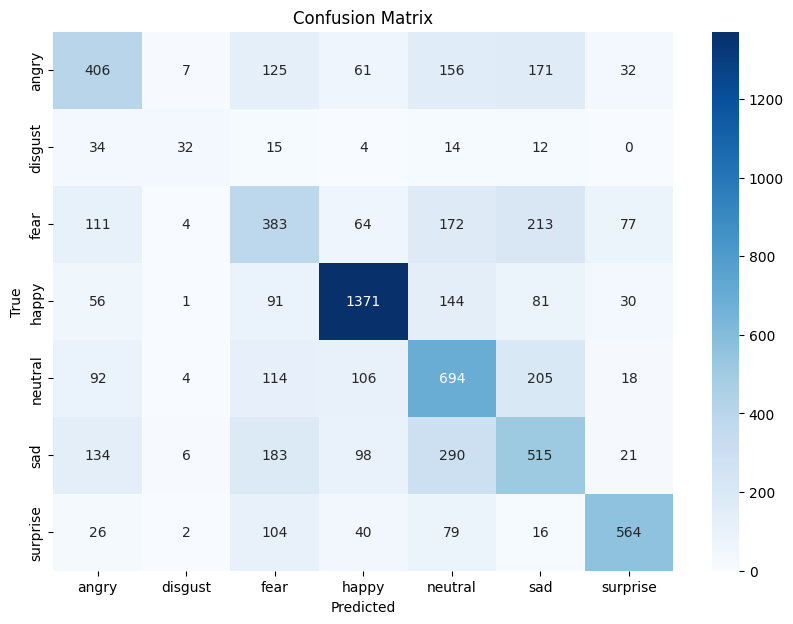

The predicted emotion for the uploaded image is: disgust


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from deepface import DeepFace
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Load and preprocess dataset
def load_images_for_deepface(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path)  # Load as RGB (DeepFace works with RGB images)
            if img is not None:
                # Convert image to RGB as DeepFace expects RGB input
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
    return images, labels

# Load train and test sets
train_dir = '/content/train'  # Change this to your dataset path
val_dir = '/content/test'     # Change this to your dataset path
X_train, y_train = load_images_for_deepface(train_dir)
X_test, y_test = load_images_for_deepface(val_dir)

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# DeepFace emotion detection
def detect_emotions_deepface(images):
    predicted_labels = []
    for img in tqdm(images):
        try:
            # Analyze the image with DeepFace
            emotion_analysis = DeepFace.analyze(img, actions=['emotion'], enforce_detection=False)
            # Get the predicted emotion
            dominant_emotion = emotion_analysis[0]['dominant_emotion']  # Access the first result
            predicted_labels.append(dominant_emotion)
        except Exception as e:
            print(f"Error processing image: {e}")
            predicted_labels.append('unknown')  # Append 'unknown' for problematic images
    return predicted_labels

# Make predictions using DeepFace
y_pred = detect_emotions_deepface(X_test)

# Filter out 'unknown' predictions and corresponding test samples
valid_indices = [i for i, pred in enumerate(y_pred) if pred != 'unknown']
y_pred_filtered = [y_pred[i] for i in valid_indices]
y_test_filtered = [y_test[i] for i in valid_indices]

# Convert predicted emotions to numerical labels for comparison
y_pred_encoded = label_encoder.transform(y_pred_filtered)
y_test_encoded_filtered = label_encoder.transform(y_test_filtered)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded_filtered, y_pred_encoded)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix and classification report
cm = confusion_matrix(y_test_encoded_filtered, y_pred_encoded)
report = classification_report(y_test_encoded_filtered, y_pred_encoded, target_names=label_encoder.classes_, zero_division=1)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Function to test and predict a single image
def predict_emotion_deepface(image_path):
    img = cv2.imread(image_path)  # Load the image as RGB
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        result = DeepFace.analyze(img, actions=['emotion'], enforce_detection=False)
        predicted_emotion = result[0]['dominant_emotion']
        return predicted_emotion
    else:
        return "Image not found or unable to load"

# Example usage: Predict the emotion of a new uploaded image
uploaded_image_path = '/content/test/disgust/PrivateTest_29901781.jpg'  # Change this to the path of the uploaded image
predicted_emotion = predict_emotion_deepface(uploaded_image_path)
print(f'The predicted emotion for the uploaded image is: {predicted_emotion}')


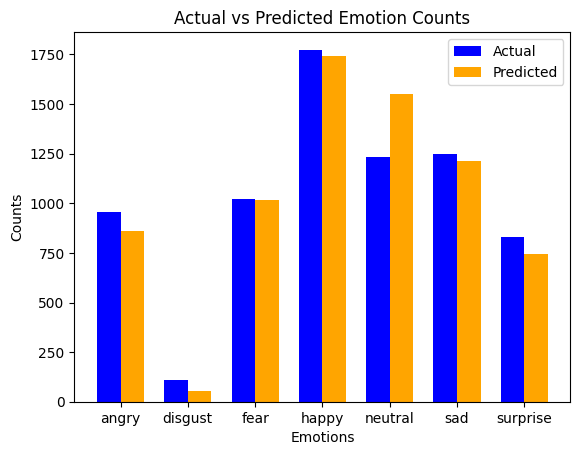

In [ ]:
def plot_actual_vs_predicted(y_test, y_pred, label_encoder):
    # Count occurrences of actual and predicted labels
    actual_counts = np.unique(y_test, return_counts=True)[1]
    predicted_counts = np.unique(y_pred, return_counts=True)[1]

    emotions = label_encoder.classes_

    # Create DataFrame for plotting
    actual_data = dict(zip(emotions, actual_counts))
    predicted_data = dict(zip(emotions, predicted_counts))

    # Create bar plot
    bar_width = 0.35
    index = np.arange(len(emotions))

    plt.bar(index, actual_counts, bar_width, label='Actual', color='blue')
    plt.bar(index + bar_width, predicted_counts, bar_width, label='Predicted', color='orange')

    plt.xlabel('Emotions')
    plt.ylabel('Counts')
    plt.title('Actual vs Predicted Emotion Counts')
    plt.xticks(index + bar_width / 2, emotions)
    plt.legend()
    plt.show()

plot_actual_vs_predicted(y_test_encoded_filtered, y_pred_encoded, label_encoder)
